In [32]:
import pandas
import math
import scipy.misc

import numpy as np

from PIL import Image
import os
import numpy as np
import scipy.misc

import json

import shapely.geometry
from geopandas_osm import osm
from shapely.geometry import shape

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2

from shapely.wkt import loads

import pandas as pd
import json

import geojson
import geopandas as gpd
from geojson import Feature, Point, FeatureCollection

In [33]:
def tile2long(x,z):
    return x / math.pow(2, z) * 360 - 180

def tile2lat(y,z):
    n = math.pi - 2 * math.pi * y / math.pow(2, z)
    return 180 / math.pi * math.atan(0.5 * (math.exp(n) - math.exp(-n)))

lat_tile_gap = 0.01247771997
lon_tile_gap = 0.02197265625
# lat_tile_gap = 0.02
# lon_tile_gap = 0.04

**create poly from sentinel**

In [34]:
tile_base_path = '../media/combined_37_UDB/'

z = '14'
x = '9918'
y = '11213'

file_path = tile_base_path + '%s/%s/%s.png' % (z, x, y)

tile_lat_min, tile_long_min = abs(tile2lat(float(y), float(z))), tile2long(float(x), float(z))
tile_lat_max, tile_long_max = tile_lat_min + lat_tile_gap, tile_long_min + lon_tile_gap

print(tile_lat_min, tile_long_min)
print(tile_lat_max, tile_long_max)

55.14120964449506 37.9248046875
55.153687364465064 37.94677734375


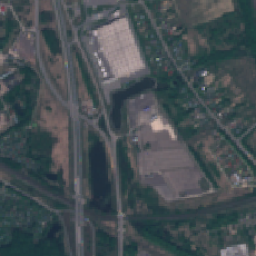

In [36]:
Image.open(file_path)

In [37]:
o = {
#     "coordinates": [[[tile_lat_min, tile_long_min], [tile_lat_max, tile_long_min], [tile_lat_max, tile_long_max], [tile_lat_min, tile_long_max], [tile_lat_min, tile_long_min]]], 
    "coordinates": [[[tile_long_min, tile_lat_min], [tile_long_min, tile_lat_max], [tile_long_max, tile_lat_max], [tile_long_max, tile_lat_min], [tile_long_min, tile_lat_min]]], 
   "type": "Polygon"
}

In [38]:
s = json.dumps(o)

# Convert to geojson.geometry.Polygon
g1 = geojson.loads(s)

# Feed to shape() to convert to shapely.geometry.polygon.Polygon
# This will invoke its __geo_interface__ (https://gist.github.com/sgillies/2217756)
g2 = shape(g1)

In [39]:
my_feature = Feature(geometry=g2)

In [40]:
collection = FeatureCollection([my_feature])

In [42]:
col = gpd.GeoDataFrame.from_features(collection['features'])
col

,geometry
0,"POLYGON ((37.9248046875 55.14120964449506, 37...."


**download tags from osm**

In [73]:
tag = 'building'

In [74]:
df = osm.query_osm('way', col.ix[0].geometry, recurse='down', tags=tag)
objs = df[df.type == 'LineString'][[tag, 'geometry']]
if tag == 'building':
    objs.geometry = objs.geometry.map(lambda x: shapely.geometry.polygon.Polygon(x))

/opt/anaconda3/lib/python3.5/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


In [77]:
objs.head()

,building,geometry
0,yes,"POLYGON ((37.9312585 55.1534259, 37.9316434 55..."
1,yes,"POLYGON ((37.9463672 55.1422632, 37.9466055 55..."
2,yes,"POLYGON ((37.9361648 55.1469966, 37.9361746 55..."
3,yes,"POLYGON ((37.9362 55.1471085, 37.9362117 55.14..."
4,yes,"POLYGON ((37.9362624 55.1469836, 37.9362909 55..."


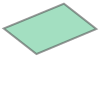

In [78]:
objs.geometry.values[56]

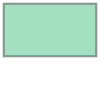

In [80]:
col.ix[0].geometry

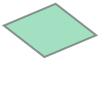

In [84]:
col.ix[0].geometry.intersection(objs.geometry.values[55])

**coords to raster**

In [85]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

In [95]:
inter = []
for geom in objs.geometry.values:
    a = col.ix[0].geometry.intersection(geom)
    if a.type == 'LineString' or a.type == 'Polygon':
        inter.append(a)

In [100]:
inter[:5]

In [104]:
list(inter[0].exterior.coords)

[(37.9312585, 55.1534259),
 (37.9316434, 55.1534838),
 (37.9316762, 55.1534125),
 (37.9312913, 55.1533547),
 (37.9312585, 55.1534259)]

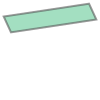

In [114]:
shapely.geometry.polygon.Polygon(list(inter[0].exterior.coords))

In [111]:
inter[0].interiors

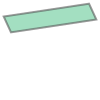

In [112]:
inter[0]

In [115]:
if tag == 'building':
    c = [np.array(list(x.exterior.coords)) for x in inter]
else:
    c = [np.array(list(x.coords)) for x in inter]
for i in range(len(c)):
    c[i][:, 1] = c[i][:, 1] - tile_lat_min
    c[i][:, 0] = c[i][:, 0] - tile_long_min

In [116]:
c_raster = [_convert_coordinates_to_raster(x, [256.0, 256.0], [lon_tile_gap, lat_tile_gap]) for x in c]

**visualize**

In [149]:
def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    for perim in perim_list:
        if tag == 'building':
            cv2.fillPoly(img_mask, [perim], class_value)
        else:
            for line_index in range(0, len(perim) - 1):
                cv2.line(img_mask, tuple(perim[line_index]), tuple(perim[line_index + 1]), class_value)
    return img_mask

In [150]:
masks = _plot_mask_from_contours([256, 256], [c_raster, []])

In [151]:
scipy.misc.imsave('my.png', np.asarray(np.flip(np.matrix(masks), axis = 0) * 255))

# Prod

# remove files
# del /s /q *_mask_highway.png

In [152]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

In [153]:
def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    for perim in perim_list:
        if tag == 'building':
            cv2.fillPoly(img_mask, [perim], class_value)
        else:
            for line_index in range(0, len(perim) - 1):
                cv2.line(img_mask, tuple(perim[line_index]), tuple(perim[line_index + 1]), class_value)
    return img_mask

In [154]:
z = '14'
tile_base_path = '../media/combined_37_UDB/%s' % z
tag = 'building'

In [170]:
start_index = 64
for x in os.listdir(tile_base_path)[start_index:]:
    for y in os.listdir(tile_base_path + '/' + str(x) + '/'):
        
        if 'mask' in y or 'ipynb_checkpoints' in y:
            continue
        
        y = y.strip('.png')
        
        tile_lat_min, tile_long_min = abs(tile2lat(float(y), float(z))), tile2long(float(x), float(z))
        tile_lat_max, tile_long_max = tile_lat_min + lat_tile_gap, tile_long_min + lon_tile_gap
        
        o = {
                "coordinates": [[[tile_long_min, tile_lat_min], [tile_long_min, tile_lat_max], [tile_long_max, tile_lat_max], [tile_long_max, tile_lat_min], [tile_long_min, tile_lat_min]]], 
               "type": "Polygon"
            }
        s = json.dumps(o)
        g1 = geojson.loads(s)
        g2 = shape(g1)
        my_feature = Feature(geometry=g2)
        collection = FeatureCollection([my_feature])
        col = gpd.GeoDataFrame.from_features(collection['features'])
        
        try:
            df = osm.query_osm('way', col.ix[0].geometry, recurse='down', tags=tag)
            df = df[df.type == 'LineString'][[tag, 'geometry']]
            if tag == 'building':
                df.geometry = df.geometry.map(lambda x: shapely.geometry.polygon.Polygon(x))
        except KeyError as e:
            print(e)
            continue
    
        inter = []
        for geom in df.geometry.values:
            a = col.ix[0].geometry.intersection(geom)
            if a.type == 'LineString' or a.type == 'Polygon':
                inter.append(a)

        if tag == 'building':
            c = [np.array(list(x.exterior.coords)) for x in inter]
        else:
            c = [np.array(list(x.coords)) for x in inter]
        for i in range(len(c)):
            c[i][:, 1] = c[i][:, 1] - tile_lat_min
            c[i][:, 0] = c[i][:, 0] - tile_long_min
        c_raster = [_convert_coordinates_to_raster(i, [256.0, 256.0], [lon_tile_gap, lat_tile_gap]) for i in c]

        masks = _plot_mask_from_contours([256, 256], [c_raster, []])

#         scipy.misc.imsave(tile_base_path + '/%s/%s_mask_%s.png' % (x, y, tag), np.asarray(np.flip(np.matrix(masks), axis = 0) * 255))

        masks = np.asarray(np.flip(np.matrix(masks), axis = 0) * 255)
        res = np.zeros([256, 256, 3], np.uint8)
        for i, ri in enumerate(masks):
            for j, rj in enumerate(ri):
                res[i][j] = [0, rj, 0]
        scipy.misc.imsave(tile_base_path + '/%s/%s_mask_%s.png' % (x, y, tag), res)

        print(tile_base_path + '/%s/%s_mask_%s.png' % (x, y, tag), 'done')

#         break

/opt/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/opt/anaconda3/lib/python3.5/site-packages/geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


../media/combined_37_UDB/14/9969/11209_mask_building.png done
../media/combined_37_UDB/14/9969/11210_mask_building.png done
'lon'
'lon'
'lon'
'lon'
'lon'
'lon'
'lon'
'lon'
'lon'
../media/combined_37_UDB/14/9969/11220_mask_building.png done
'lon'
'lon'
'lon'
'lon'
'lon'
'lon'
'lon'
'lon'
../media/combined_37_UDB/14/9969/11229_mask_building.png done
../media/combined_37_UDB/14/9969/11230_mask_building.png done
../media/combined_37_UDB/14/9969/11231_mask_building.png done
../media/combined_37_UDB/14/9969/11232_mask_building.png done
../media/combined_37_UDB/14/9969/11233_mask_building.png done
../media/combined_37_UDB/14/9969/11234_mask_building.png done
'lon'
'lon'
'lon'
../media/combined_37_UDB/14/9969/11238_mask_building.png done
../media/combined_37_UDB/14/9969/11239_mask_building.png done
'lon'
'lon'
'lon'
'lon'
../media/combined_37_UDB/14/9969/11244_mask_building.png done
'lon'
../media/combined_37_UDB/14/9969/11246_mask_building.png done
'lon'
'lon'
'lon'
'lon'
'lon'
'lon'
'lon'
'l